In [1]:
import numpy as np
import geopandas

In [2]:
from stroke_maps.catchment import Catchment
from stroke_maps.combine import Combine
import stroke_maps.geo
import stroke_maps.plot

combine = Combine()

## Setup for scenarios

In [3]:
merge_dicts = dict(
    df_transfer = {},
    df_lsoa = {},
    df_units = {},
)

In [4]:
units_to_include = [
    'GL13NN',
    'SN36BB',
    'BS105NB',
    'EX314JB',
    'PL68DH',
    'TR13LQ',
    'EX25DW',
    'BA13NG',
    'SP28BJ',
    'TA15DA',
    'TQ27AA',
    'BS234TQ',
    'BA214AT',
]

## Scenario 1

In [5]:
scenario_name = 'drip-and-ship'

In [6]:
# Catchment overwrites default values
catchment = Catchment({
    # "setup": setup,
    'name': scenario_name,
    "run_duration": 5,  # years
})

df_units = catchment.get_unit_services()

df_units = df_units.reset_index()

mask = df_units['postcode'].isin(units_to_include)
df_units.loc[mask, 'selected'] = 1

df_units = df_units.set_index('postcode')

In [7]:
df_units['stroke_team'][df_units['selected'] == 1]

postcode
BA13NG                     Royal United Hospital Bath
EX314JB     North Devon District Hospital, Barnstaple
PL68DH                   Derriford Hospital, Plymouth
EX25DW                Royal Devon and Exeter Hospital
GL13NN     Gloucestershire Royal Hospital, Gloucester
SN36BB                Great Western Hospital, Swindon
TA15DA                Musgrove Park Hospital, Taunton
BS105NB            North Bristol Hospital (Southmead)
SP28BJ                    Salisbury District Hospital
TQ27AA                                Torbay Hospital
TR13LQ                 Royal Cornwall Hospital, Truro
BS234TQ    Weston General Hospital, Weston-super-Mare
BA214AT                      Yeovil District Hospital
Name: stroke_team, dtype: object

In [8]:
dict_useful_data = catchment.main(df_units)

Gather data for later combination:

In [9]:
# Update big dictionary of Dataframes:
merge_dicts['df_units'][scenario_name] = dict_useful_data['df_units']
merge_dicts['df_transfer'][scenario_name] = dict_useful_data['df_transfer']
merge_dicts['df_lsoa'][scenario_name] = dict_useful_data['df_lsoa']

## Scenario 2

In [10]:
scenario_name = 'mothership'

In [11]:
# Catchment overwrites default values
catchment = Catchment({
    # "setup": setup,
    'name': scenario_name,
    "run_duration": 5,  # years
})

df_units = catchment.get_unit_services()

df_units = df_units.reset_index()

# Set all non-MT units to have no IVT:
mask = df_units['use_mt'] == 0
df_units.loc[mask, 'use_ivt'] = 0

mask = (
    (df_units['postcode'].isin(units_to_include)) &
    (df_units['use_ivt'] == 1)
)
df_units.loc[mask, 'selected'] = 1


df_units = df_units.set_index('postcode')

In [12]:
df_units['stroke_team'][df_units['selected'] == 1]

postcode
PL68DH           Derriford Hospital, Plymouth
BS105NB    North Bristol Hospital (Southmead)
Name: stroke_team, dtype: object

In [13]:
dict_useful_data = catchment.main(df_units)

Gather data for later combination:

In [14]:
# Update big dictionary of Dataframes:
merge_dicts['df_units'][scenario_name] = dict_useful_data['df_units']
merge_dicts['df_transfer'][scenario_name] = dict_useful_data['df_transfer']
merge_dicts['df_lsoa'][scenario_name] = dict_useful_data['df_lsoa']

In [15]:
dict_useful_data['df_lsoa']

,,unit_travel_time,unit_postcode,selected
lsoa,lsoa_code,,,
Adur 001A,E01031349,17.6,BN25BE,0
Adur 001B,E01031350,18.7,BN25BE,0
Adur 001C,E01031351,19.8,BN25BE,0
Adur 001D,E01031352,19.8,BN25BE,0
Adur 001E,E01031370,19.8,BN25BE,0
...,...,...,...,...
York 024B,E01013341,38.0,LS13EX,0
York 024C,E01013342,38.0,LS13EX,0
York 024D,E01013423,34.8,LS13EX,0


## Combine multiple scenarios

In [16]:
combo_df_units = combine.combine_units(
    merge_dicts['df_units'])

combo_df_transfer = combine.combine_transfer(
    merge_dicts['df_transfer'])

combo_df_lsoa = combine.combine_lsoa(
    merge_dicts['df_lsoa'])

## Create geometry data

In [17]:
df_regions = stroke_maps.geo.load_regions()

In [18]:
(
    gdf_boundaries_regions,
    gdf_points_units,
    gdf_lines_transfer,
    gdf_boundaries_lsoa,
    gdf_boundaries_catchment
) = stroke_maps.geo.main(
    combo_df_lsoa, combo_df_units, df_regions, combo_df_transfer
    )

## Setup for maps

Crop all geometry data to the same axis limits and assign colours to the catchment areas:

In [19]:
(
gdf_boundaries_regions,
gdf_points_units,
gdf_boundaries_catchment,
gdf_boundaries_lsoa,
gdf_lines_transfer,
box_shared,
map_extent_shared
        ) = stroke_maps.plot.main(
    gdf_boundaries_regions,
    gdf_points_units,
    gdf_boundaries_catchment,
    gdf_boundaries_lsoa,
    gdf_lines_transfer,
    crop_axis_leeway=5000
    )

/home/anna/miniconda3/envs/stroke_maps_dev/lib/python3.12/site-packages/geopandas/array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as OSGB36 / British National Grid (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))
/home/anna/miniconda3/envs/stroke_maps_dev/lib/python3.12/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/anna/miniconda3/envs/stroke_maps_dev/lib/python3.12/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

## Plotting

Combining the scenarios earlier means that these maps share axis limits even though they contain different information for each scenario.

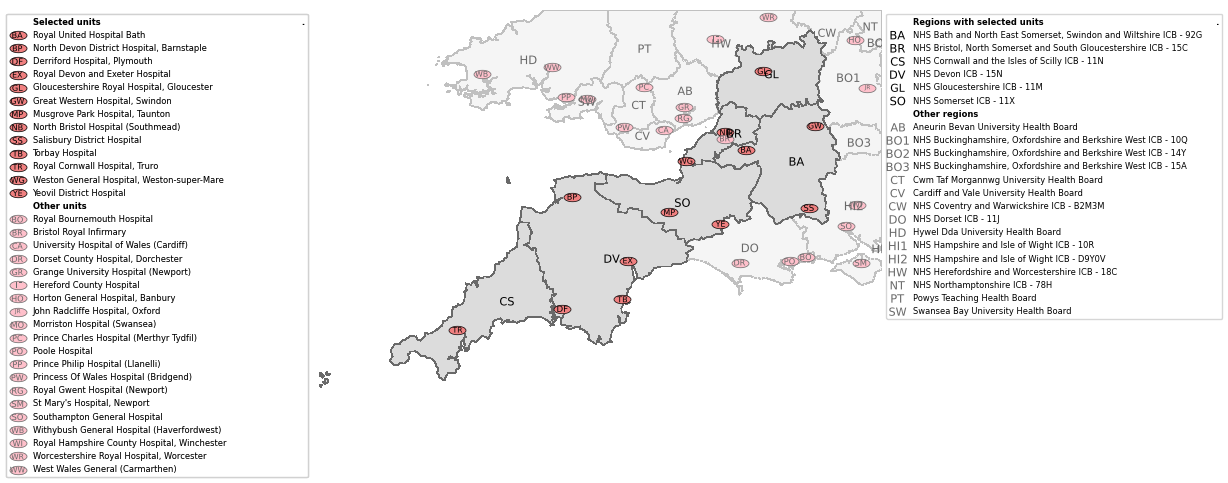

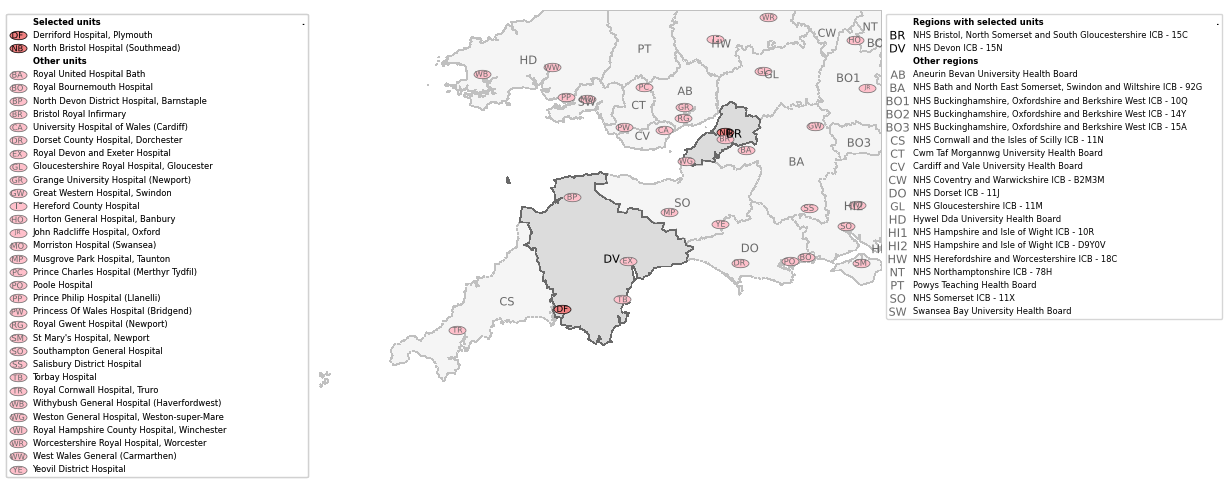

In [20]:
for scenario in ['drip-and-ship', 'mothership']:
    stroke_maps.plot.plot_map_selected_regions(
        gdf_boundaries_regions,
        gdf_points_units,
        scenario=scenario,
        map_extent=map_extent_shared
    )

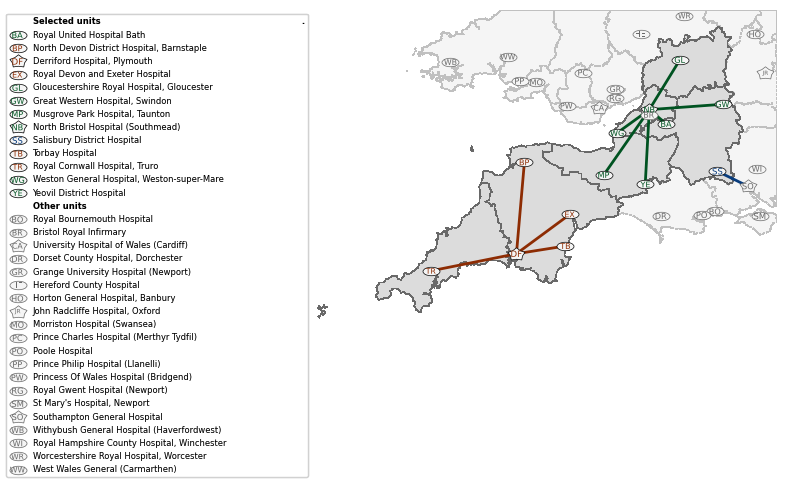

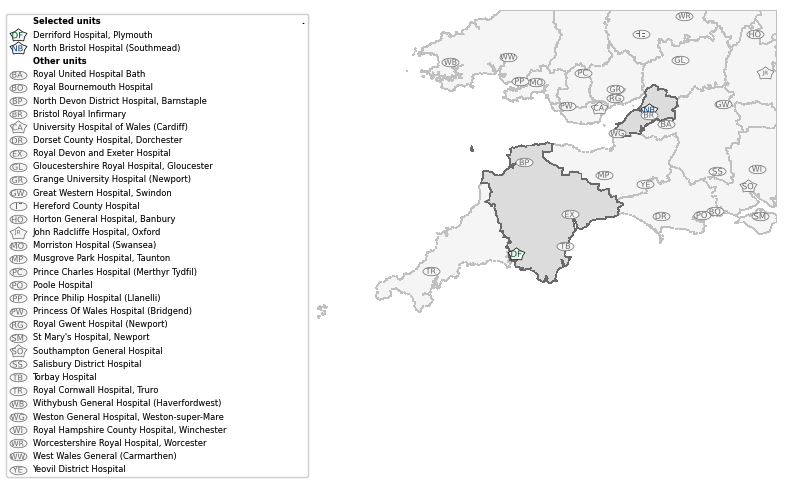

In [21]:
for scenario in ['drip-and-ship', 'mothership']:
    stroke_maps.plot.plot_map_selected_units(
        gdf_boundaries_regions,
        gdf_points_units,
        gdf_lines_transfer,
        scenario=scenario,
        map_extent=map_extent_shared
    )

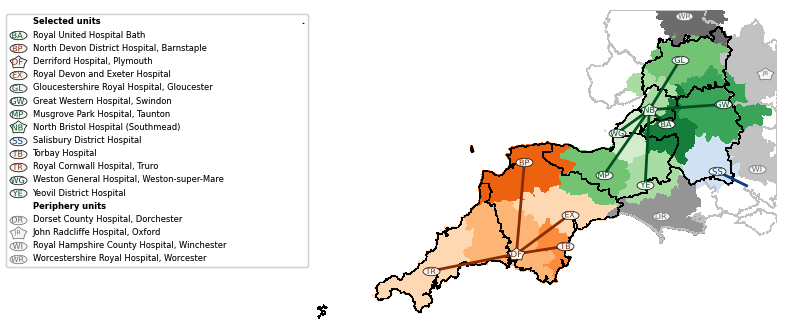

/home/anna/miniconda3/envs/stroke_maps_dev/lib/python3.12/site-packages/stroke_maps/plot_functions.py:278: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf.plot(


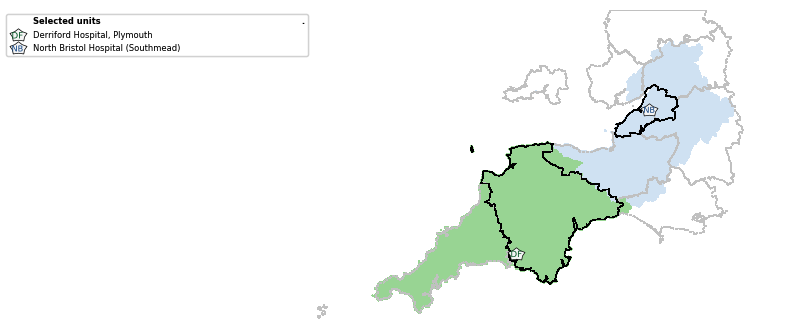

In [22]:
for scenario in ['drip-and-ship', 'mothership']:
    stroke_maps.plot.plot_map_catchment(
        gdf_boundaries_catchment,
        gdf_boundaries_regions,
        gdf_points_units,
        gdf_lines_transfer,
        scenario=scenario,
        map_extent=map_extent_shared
    )